<h2><center>Introduction to Machine Learning: Assignment 2</center></h2>

__Given date:__ March 3

__Due date:__ March 20

__Total: 25pts__



#### Question 1 Least Absolute Shrinkage and Selection Operator 

__(13pts)__

Learning a model through the OLS loss can be done very efficiently through either gradient descent or even through the Normal equations. The same is true for ridge regression. For the Lasso formulation however, the non differentiability of the absolute value at $0$ makes the learning more tricky.



One approach, known as _ISTA_ (see Amir Beck and Marc Teboulle, _A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems_) consists in combining traditional gradient descent steps with a projection onto the $\ell_1$ norm ball. Concretely, for the LASSO objective 

\begin{align}
\ell(\boldsymbol \beta) = \|\boldsymbol X\boldsymbol \beta - \boldsymbol t\|^2_2 + \lambda \|\boldsymbol \beta\|_1
\end{align}

where $\boldsymbol \beta = (\beta_1, \beta_2,\ldots, \beta_D)$ (note that we don't include the bias) and the feature vectors $\left\{\boldsymbol  x_i\right\}_{i=1}^N$ (corresponding to the rows of the matrix $\boldsymbol X$) as well as the targets $t_i$ are assumed to be centered, i.e.
\begin{align}
\boldsymbol x_{ij} \leftarrow \boldsymbol x_{ij}-  \frac{1}{N}\sum_{i=1}^{N} x_{ij}\\
t_i \leftarrow t_i - \frac{1}{N}\sum_{i=1}^N t_i
\end{align}

(Note that this is equivalent to taking $\beta_0 = \frac{1}{N}\sum_{i=1}^N t_i$)
The ISTA update takes the form 

\begin{align}
\boldsymbol \beta^{k+1} \leftarrow \mathcal{T}_{\lambda \eta} (\boldsymbol \beta^{k} - 2\eta \mathbf{X}^T(\mathbf{X}\mathbf{\beta} - \mathbf{t}))
\end{align}

where $\mathcal{T}_{\lambda \eta}(\mathbf{x})_i$ is the thresholding operator defined component-wise as

\begin{align}
\mathcal{T}_{\lambda t}(\mathbf{\beta})_i = (|\beta_i| - \lambda t)_+ \text{sign}(\beta_i)
\end{align}

In the equations above, $\eta$ is an appropriate step size and $(x)_+ = \max(x, 0)$ 

##### Question 1.1. (5pts)

Complete the function 'ISTA' which must return a final estimate for the regression vector $\mathbf{\beta}$ given a feature matrix $\mathbf{X}$, a target vector $\mathbf{t}$ (the function should include the centering steps for $\mathbf{x}_i$ and $t_i$) regularization weight $\lambda$, and the choice for the learning rate $\eta$. 

In [3]:
def ISTA(beta_init, X, t, lbda, eta):
    
    '''The function takes as input an initial guess for beta, a set 
    of feature vectors stored in X and their corresponding 
    targets stored in t, a regularization weight lbda, 
    step size parameter eta and must return the 
    regression weights following from the minimization of 
    the LASSO objective'''
    
    beta_LASSO = np.zeros((np.shape(X)[0], 1))
    
    # add your code here
    
    
    return beta_LASSO
    

##### Question 1.2.  (3pts)

Apply your algorithm to the data (in red) given below for polynomial features up to degree 8-10 and for various values of $\lambda$. Display the result on top of the true model (in blue).

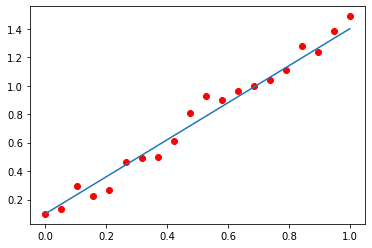

In [4]:
import numpy as np
import matplotlib.pyplot as plt


x = np.linspace(0,1,20)
xtrue = np.linspace(0,1,100)
t_true = 0.1 + 1.3*xtrue

t = 0.1 + 1.3*x

tnoisy  = t+np.random.normal(0,.1,len(x))

plt.scatter(x, tnoisy, c='r')
plt.plot(xtrue, t_true)

plt.show()

##### Question 1.3 FISTA (3pts)

It is possible to improve the ISTA updates by combining them with Nesterov accelerated gradient descent. The resulting update, known as FISTA can read, for a constant step size, by 
letting $\mathbf{y}^{(1)} = {\boldsymbol \beta}^{(0)}$, $\eta^1 = 1$ and then using 

\begin{align}
\left\{
\begin{array}{l}
&\boldsymbol{\beta}^{k+1} = \text{ISTA}(\mathbf{y}^{k})\\
&\eta^{(k+1)} = \frac{1+\sqrt{1+4(\eta^{(k)})^2}}{2}\\
&\mathbf{y}^{(k+1)} = \mathbf{x}^{(k)} + \left(\frac{\eta^{(k)} - 1}{\eta^{(k+1)}}\right)\left({\boldsymbol\beta}^{(k)} - {\boldsymbol\beta}^{(k-1)}\right)\end{array}\right.
\end{align}

Here $\text{ISTA}$ denotes a __single__ ISTA update.

Complete the function below so that it performs the FISTA iterations. Then apply it to the data given in question 1.2.

In [5]:
def FISTA(X, t, eta0, beta0, lbda):
    
    '''function should return the solution to the minimization of the
    the LASSO objective ||X*beta - t||_2^2 + lambda*||beta||_1
    by means of FISTA updates'''
    
    
    
    return beta_LASSO 

##### Question 1.4. (2pts)

Compare the ISTA and FISTA updates by plotting the evolution of the loss $\ell(\mathbf{\beta})$ as a function of the iterations for both approaches. Take a sufficient number of iterations (1000 - 10,000)

In [6]:
import matplotlib.pyplot as plt



FISTA_loss = np.zeros((max_iter, 1))
ISTA_loss = np.zeros((max_iter, 1))

plt.plot(FISTA_loss)
plt.plot(ISTA_loss)
plt.show()

NameError: name 'max_iter' is not defined

#### Question 2. Classification Trees

__(12pts)__

##### Question 2.1 Logistic regression (5pts)

As we saw during the lectures, one approach at learning a (binary) linear discriminant is to combine the sigmoid activation function with the linear discriminant $\beta_0 + \mathbf{\beta}^T \mathbf{x}$. We then assume that the probability of having a particular target ($0$ vs $1$) follows a Bernoulli with parameter $\sigma(\tilde{\mathbf{\beta}}^T\tilde{\mathbf{x}})$. i.e. we have 

$$\left\{\begin{array}{l}
P(t = 1|x) = \sigma(\mathbf{\beta}^T\mathbf{x})\\
P(t = 0|x) = 1-\sigma(\mathbf{\beta}^T\mathbf{x})\end{array}\right.$$

The total density can read from the product of each of the independent densities as 

$$P(\left\{t_i\right\}_{i=1}^N) = \prod_{i=1}^N \sigma(\mathbf{\beta}^T\mathbf{x})^{t^{(i)}}(1-\sigma(\mathbf{\beta}^T\mathbf{x}))^{1-t^{(i)}}$$

we can then take the log and compute the derivatives of the resulting expression with respect to each weight $\beta_j$. Implement this approach below. Recall that the derivative of sigma has a _simple expression_. The first function below might not be needed in the implementation of the function 'solve_logisticRegression'

In [ ]:
# Step 1 define the sigmoid activation and its derivative


def sigmoid(x):

    '''the function should return the sigmoid and its derivative at all the 
    points encoded in the vector x (be careful of the fact that )'''
    
    
    return sig, deriv_sig


def solve_logisticRegression(xi, ti, beta0, maxIter, eta):
    
    '''The function should return the vector of weights in logistic regression
    following from gradient descent iterations applied to the log likelihood function'''
    
    
    
    return beta



#### Question 2.2 Logistic regression and Fisher scoring (5pts)

An interesting aspect of the MLE estimator in logistic regression (as opposed to other objective functions) is that the Hessian is positive definite. We can thus improve the iterations by using a second order method (such as Newton's method) where the simpler gradient iterations $\mathbf{\beta}^{k+1}\leftarrow \mathbf{\beta}^k - \eta\nabla \ell(\mathbf{\beta}^k)$ are replaced by 

$$\mathbf{\beta}^{k+1}\leftarrow \mathbf{\beta}^k - \eta H^{-1}(\mathbf{\beta^k})\nabla \ell(\mathbf{\beta}^k)$$

Start by completing the function below which should return the Hessian of the negative log likelihood. Note that we move in the direction $-\nabla_{\beta}\ell$, hence we minimize. You should there consider the negative log likelihood.  

In [ ]:
def HessianMLE(beta):
    
    '''Function should return the Hessian (see https://en.wikipedia.org/wiki/Hessian_matrix) 
    of the log likelihood at a particular value of the weights beta'''
    
    
    return HessianMatrix
    

In [ ]:
def Fisher_scoring(beta0, maxIter, eta):
    
    '''Function should compute the logistic regression classifier by relying on Fisher scoring
    iterates should start at beta0 and be applied with a learning eta'''

    while numIter<maxIter:
    
        hessian_beta = HessianMLE(beta)
        
        # if no eigenvalue is 0
        
            invHessian = # complete 
        
        # else 
        
            print('Error')
        
        betaNext = betaPrevious + eta*np.matmul(invHessian,gradient)
    


    return optimal_beta

#### Question 2.3 Comparing the two approaches. (2pts)

Compare the gradient descent iterates with the Fisher scoring iterates for the dataset given below. Plot the evolution of the log likelihood through the iterations, for both methods.  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.io
class1 = scipy.io.loadmat('class1HW1_LR.mat')['class1']
class0 = scipy.io.loadmat('class2HW1_LR.mat')['class2']

targets_class1 = np.ones(np.shape(class1)[0])
targets_class0 = np.zeros(np.shape(class0)[0])

plt.scatter(class1[:,0], class1[:,1], c = 'r')
plt.scatter(class2[:,0], class2[:,1], c = 'b')
plt.show()

